In [1]:
##################################
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np
import random
##################################

In [2]:
df = pd.read_csv("bank.csv")
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [3]:
sampled = df.sample(1000)
sampled.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3792,42,technician,married,secondary,no,2,no,no,unknown,29,may,249,2,-1,0,unknown,no
2885,26,services,single,secondary,no,50,yes,no,cellular,12,aug,153,1,-1,0,unknown,no
865,32,blue-collar,single,secondary,no,-255,no,yes,unknown,2,jul,957,3,-1,0,unknown,no
1336,26,blue-collar,single,secondary,no,856,yes,yes,cellular,30,jul,95,5,-1,0,unknown,no
4378,59,housemaid,divorced,primary,no,195,no,no,unknown,5,may,366,2,-1,0,unknown,no


In [4]:
new_df = np.array(sampled[['age','balance']])
new_df

array([[   29, 22171],
       [   33,    86],
       [   27,  -151],
       ...,
       [   32,  -255],
       [   26,   856],
       [   59,   195]], dtype=int64)

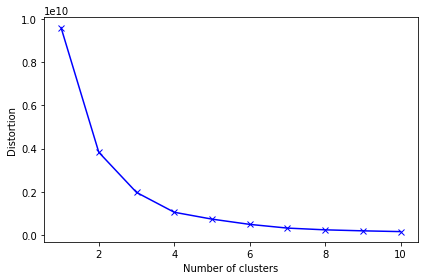

In [5]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(new_df)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()

plt.show()

In [6]:
df = pd.read_csv("bank.csv")
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [7]:
sampled = df.sample(1000)
sampled.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
463,35,blue-collar,divorced,secondary,no,3102,yes,no,cellular,20,nov,138,1,-1,0,unknown,no
2885,26,services,single,secondary,no,50,yes,no,cellular,12,aug,153,1,-1,0,unknown,no
4500,38,admin.,married,secondary,no,4196,yes,no,cellular,12,may,193,2,-1,0,unknown,no
536,45,management,married,tertiary,no,1529,no,no,cellular,30,jun,160,1,-1,0,unknown,no
1714,57,technician,married,primary,no,0,no,no,unknown,5,jun,58,8,-1,0,unknown,no


In [8]:
new_df = np.array(sampled[['age','balance']])
new_df

array([[  55, 1011],
       [  43, 3403],
       [  24, 1222],
       ...,
       [  38, 4196],
       [  45, 1529],
       [  57,    0]], dtype=int64)

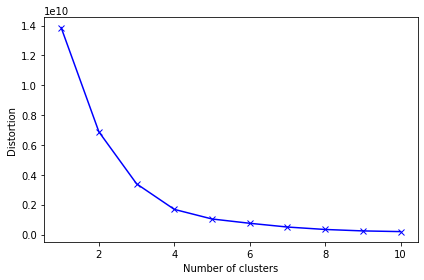

In [9]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(new_df)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()

plt.show()